# **Local Invariant Feature with SIFT descriptors**
## Image Processing and Computer Vision - Lab Session No. 2


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/ComputerVision_labs/lab02/lab_session_2_images.zip ./
!unzip lab_session_2_images.zip

Mounted at /content/drive
Archive:  lab_session_2_images.zip
  inflating: bishop.jpg              
  inflating: box_in_scene.png        
  inflating: __MACOSX/._box_in_scene.png  
  inflating: box.png                 
  inflating: __MACOSX/._box.png      
  inflating: panorama_left_rgb.jpg   
  inflating: panorama_left.jpg       
  inflating: panorama_right_rgb.jpg  
  inflating: panorama_right.jpg      
  inflating: scene1.jpg              
  inflating: scene2.jpg              
  inflating: scene3.jpg              
  inflating: scene4.jpg              
  inflating: scene5.jpg              
  inflating: stregatto.jpg           


##  1. Correspondences
A great variety of computer vision problems can be dealt with finding corresponding points between images.

**Corresponding points**: image points which are the projection of the same 3D position from different points of view.

Being projections, their appearances can vary greatly between one image and the other so establishing correspondences may be difficult.

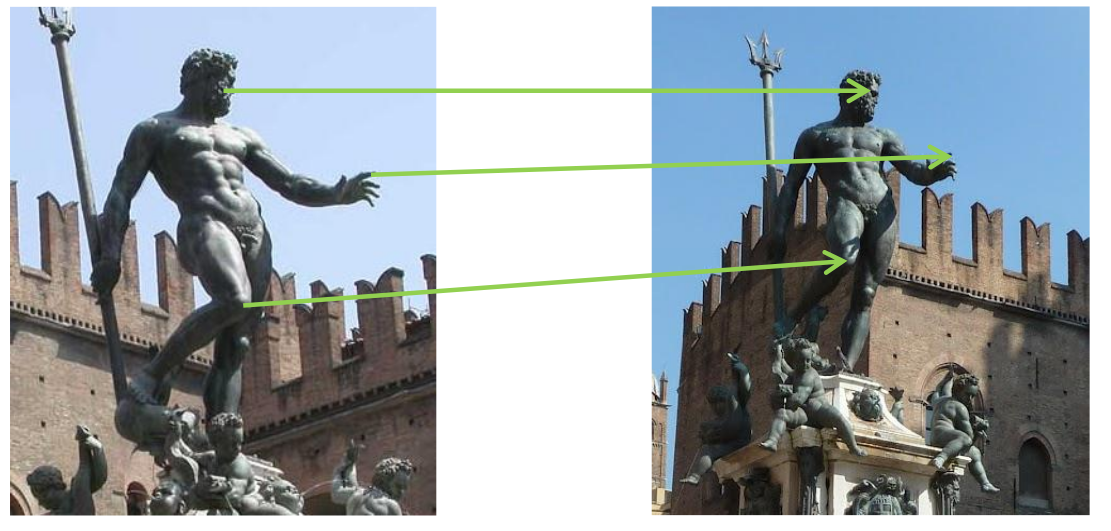

### 1.1 Examples of tasks that exploit correspondences



```
# This is formatted as code
```

#### 1.1.1 SLAM

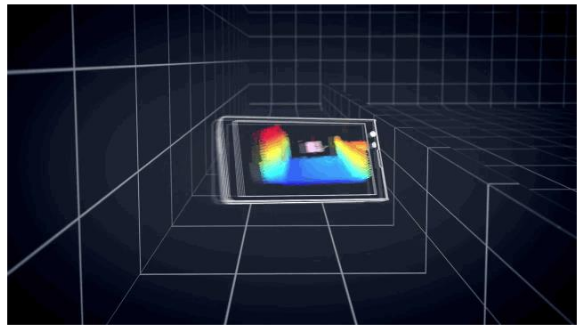

#### 1.1.2 Augmented Reality

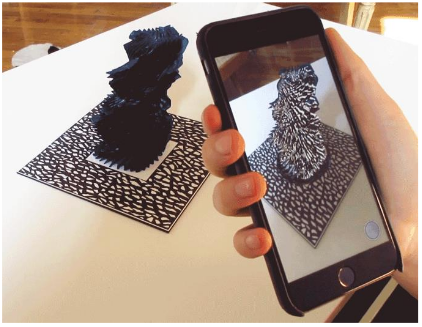



#### 1.1.3 3D Reconstruction
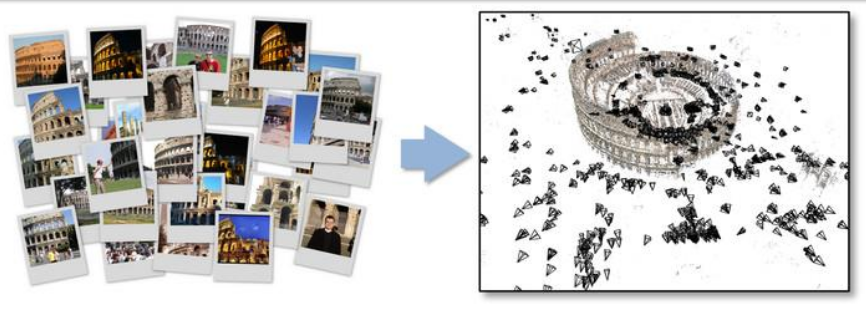


## 2. Object Detection

Object Detection consists in finding instances of objects in images (scenes), given one or more reference image depicting them (models).

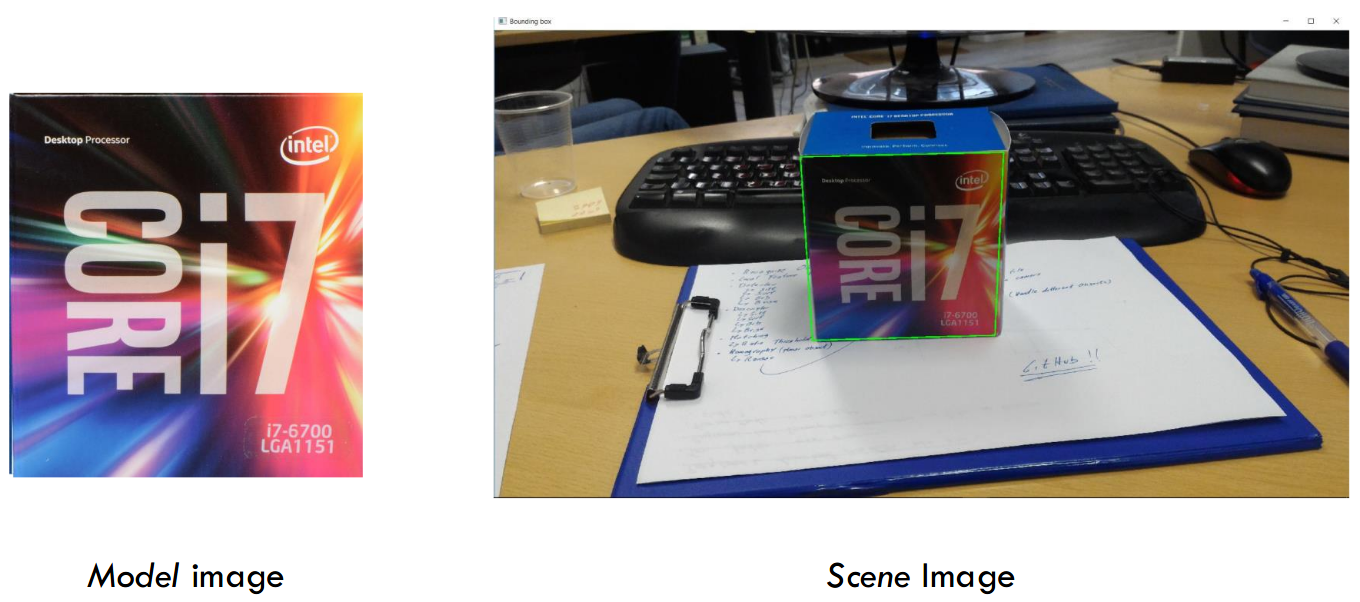

**What can go wrong? What a good detection system should handle?**

* **Scale invariance**: object in scene may appear at any scale, not only at the same resolution used for the model images;
* **Rotation invariance**: object may appear rotated or skewed in the scene;
* **Photometric invariance**: object may appear in any light condition;
* **Occlusion**: portion of the objects may not be visible in the scene;
* **Perspective distortion**: object may appear fairly different if viewed from different camera viewpoint.

### 2.1 Object Detection with CNNs

State of the art methods are based on deep learning, especially convolutional neural networks (i.e. CNNs).

**Pro**:
* Astonishing real time performances for the detection of complex and highly variable categories of objects (persons, animals, vehicles,...).

**Cons**:
* Requires thousands of model images for each category of objects we want to recognize and a lot of time to train the algorithm.

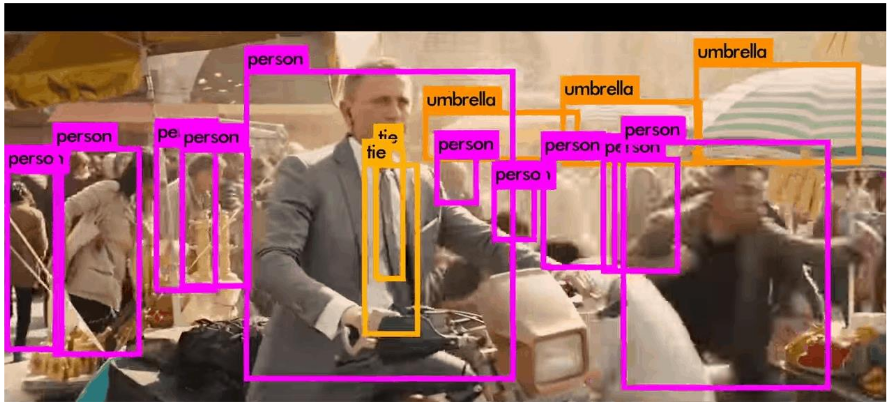

### 2.2 Object Detection with Local Invariant Features

Allows to successfully identify objects in scene from a
single model image per object.

**Pros:**
* Quite effective for the detection of textured objects;
* Scale, rotation and illuminance invariant;
* Works well under partial occlusion;
* Only one model image per object required;
* Fully implementable with openCV in few lines of code.

**Cons**:
* Suffers from changes in camera viewpoint;
* Can be slow when the number of objects to recognize increases;
* Does not work well with deformable objects or to detect categories of objects.

**Pipeline**:
1. **Detection**: identify salient repeatable points, namely **keypoints**, in model and scene images;
2. **Description**: create a unique description of each point, usually based on its local pixel neighborhood;
3. **Matching**: match points from scene and model according to a similarity function between the descriptors;
4. **Position estimation**: estimate the position of the object in the scene image given enough matching points.

## 3. Implementation of an Object Detection Pipeline with Local Invariant Features paradigm in OpenCV

Let us now try to implement an object detection pipeline using SIFT detector and descriptor.

As usual, let us first import the needed Python libraries:

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Let us load a train image:

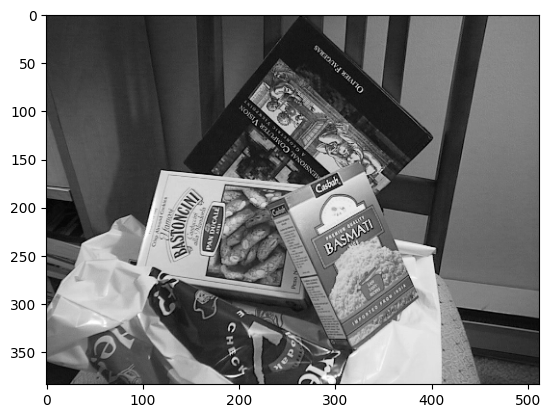

In [ ]:
img_train = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_train, cmap = 'gray')
plt.show()

And a query image:

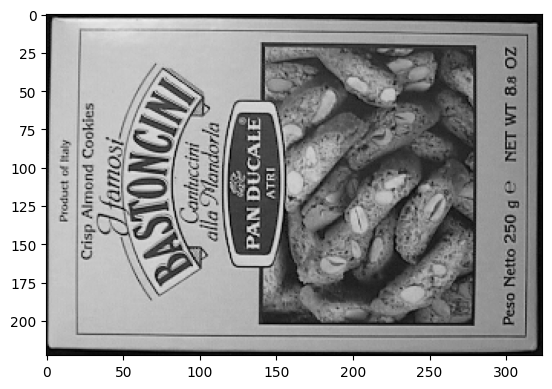

In [ ]:
img_query = cv2.imread('box.png', 0)
plt.imshow(img_query, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

### 3.1 Keypoint Detection

Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators.
2. Keep only the points that are local maxima.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).   

Let us now find keypoints in the scene based on the sift detector. We first initialize the SIFT detector object in the following way:


In [ ]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of the query image:

In [ ]:
# find the keypoints and descriptors with SIFT
kp_query = sift.detect(img_query)

We can print a lot of useful information of a keypoint in the following way:

In [ ]:
# Number of keypoints
print(len(kp_query))

# Location of the keypoint
print(kp_query[4].pt)

# Scale
print(kp_query[4].size)

# Rotation
print(kp_query[4].angle)

604
(9.602896690368652, 118.08353424072266)
2.2116410732269287
216.16510009765625


In case we want to visualize them we can use the following function:

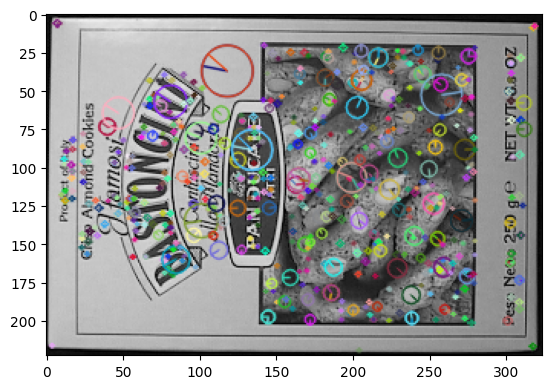

In [ ]:
# Visualize keypoints with drawKeypoints.
#Use flag DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to show scale and orientation of keypoints.
img_visualization = cv2.drawKeypoints(img_query, kp_query, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

Now, let us find and draw the keypoints for the train image:

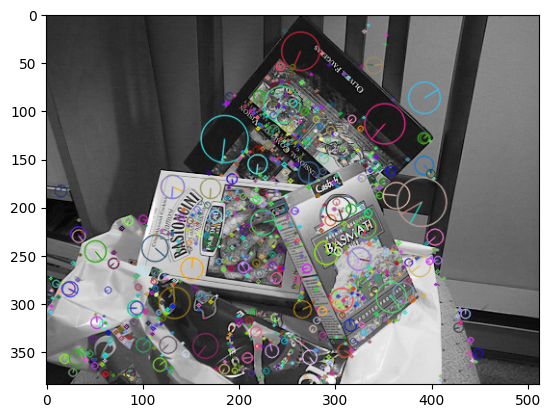

In [ ]:
# compute keypoints for the train image
kp_train = sift.detect(img_train)

# show the keypoints
img=cv2.drawKeypoints(img_train, kp_train, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()



```
# This is formatted as code
```

### 3.2 Keypoints Description

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).

A good keypoint descriptor should be:
* Repeatable: the descriptions computed at homologus points should be as similar as possible.
* Distinctive: capture the salient informations around the keypoint despite various nuisances (e.g. light changes).
* Compact: minimize memory occupancy to allow efficient matching.
* Fast: it is usually applied to hundred or thousand of keypoints in each image.

**Given the patch surrounding a keypoint, can we use raw pixel intensities as descriptor?**

Different algorithms provides different descriptions, the common idea is to describe keypoints using an array (histogram) of values that encodes the appearance of its local neighborhood. The size of the support depends on the scale associated to the keypoint (i.e. scale invariance).
The descriptor are computed according to the orientation associated to the  keypoint (i.e rotation invariance).

The histogram used for the description could be made of:
* floats: more distinctive, high memory footprint
* bits: less distinctive, small memory footprint (binary descriptors)

Some well known algorithms:
1. **SIFT**: 128 floats array (4.096 bytes for each descriptor)
2. **SURF**: 64 floats array (2.048 bytes for each descriptor)
3. **BRISK**:  512 bit array (64 bytes for each descriptor)
4. **ORB**: 256 bit array (32 bytes for each descriptor)

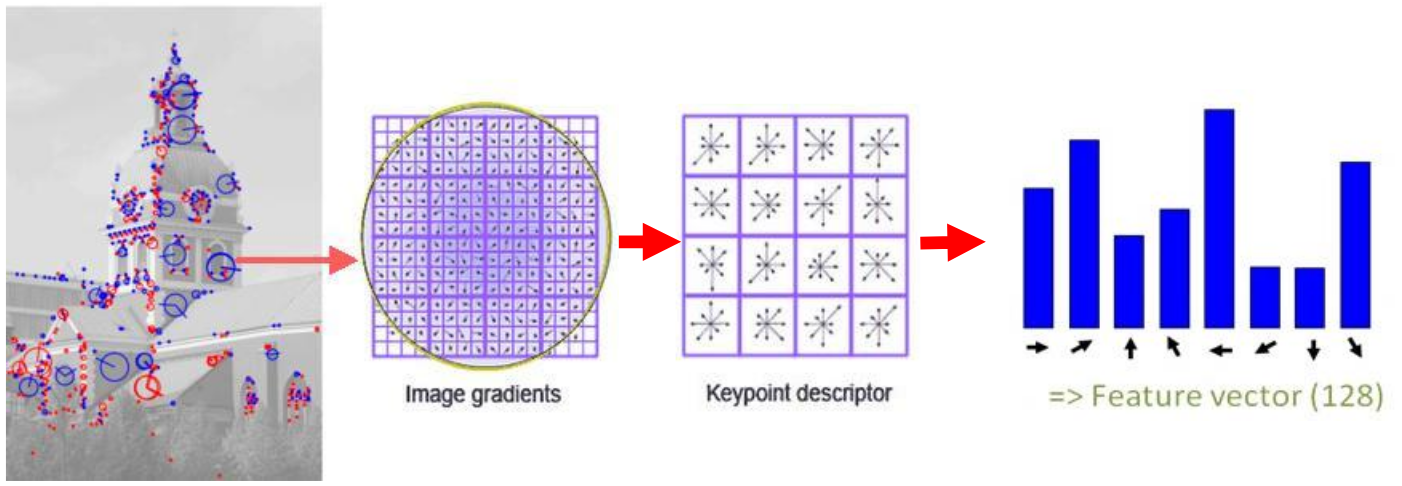

We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

In [ ]:
# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

For each keypoint we got a a 128 floats array SIFT

---

descriptor:

In [ ]:
print("Number of query descriptors: ", len(des_query))
print("Dimensionality of a SIFT descriptor: ", des_query[0].shape)
print("Type of the descriptor: ", des_query[0].dtype)

Number of query descriptors:  604
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


### 3.3 Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones.

Classic Nearest Neighbour(NN) Search problem: Given a set of points $n$ points $R=\{r_0,...,r_n\}$, a query point $q$ and a distance function $D$; find the point $r_{nn} \in R$ such that:

$D(q,r_{nn})<D(q,r_k), \forall r_k \in R$

In our scenario points are feature vectors and the distance function is Euclidean distance for floats or
Hamming distance for bits.

Naive idea - Brute force matcher:
For each keypoint $q$ detected in scene compute all the $D(q,r_{nn})$ to find the minimum. Too slow to be applied in a lot of application, may sometimes be used with binary descriptor (distance function is a simple XOR between the descriptors).

Smart idea - indexing technique:
Use efficient indexing such as KD-tree techniques borrowed from database management to speed up the search.
* Kd-tree - exact
* BBF - approximated
* LSH - for binary descriptor

**Kd-tree** may be thought of as partitioning the search space into ‘bins’ During backtracking the bins adjacent to the one containing the found leaf may be examined.

However the number of bins grow exponentially with the dimension of the space, so kd-tree does not work well for highly dimensional space.

**Approximate techniques** help speeding up the search.

For instance, we will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV.

**FLANN** contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

To implement it in **OpenCV** we can do the following.

In [ ]:
# Defining index for approximate kdtree algorithm (for solving NNB problem)
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_query,des_train,k=2)

### 3.4 Filtering False Matches in SIFT

1.   List item
2.   List item


To **filter** the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches.

The **distance ratio** between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold.

Indeed, this ratio allows helping to discriminate between **ambiguous matches** (distance ratio between the two nearest neighbors is close to one) and **well discriminated matches**.

The figure below from the SIFT paper illustrates the probability that a match is correct based on the nearest-neighbor distance ratio test.

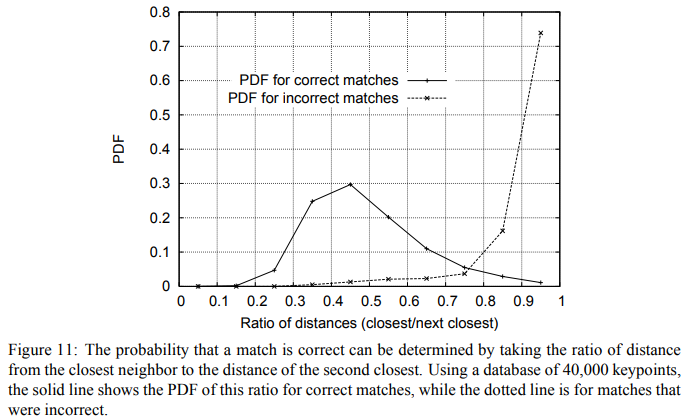

In OpenCV we iterate along all matches checking the distance ratio between the first and the second closest elements using 0.7 as distance ratio threshold:

In [ ]:
# filter good matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

### 3.5 Position Estimation

**How can we find the position of the object in scene?**

To find the position we have to compute, given the **correspondences**, a suitable transformation that brings points from the model reference system to the scene one.

**Homography**: transformation that relates any two images of the same planar surface under the pinhole camera model. An homography is a $3x3$ matrix that transforms points expressed in homogeneous coordinates; it can be decomposed in a rotation, a translation and a perspective distortion.

Given corresponding couples of points $(m,s) \in R^2$ with $m \in C_m$ and $s \in C_s$ estimate an homography means solving a linear system:

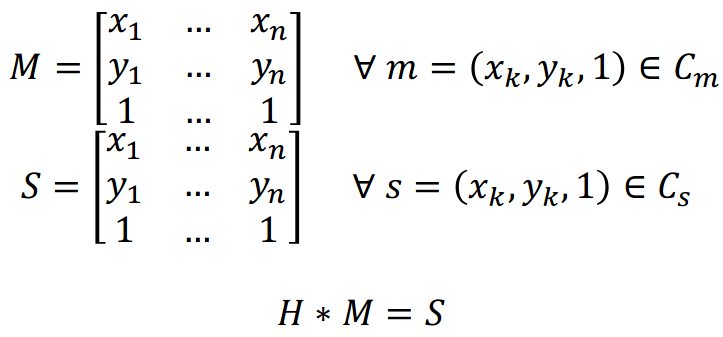

Usually those systems are over-constrained problems with no exact solution: solve minimizing error with the least square solution.

**However, bounding box obtained by transforming the corner of the model image in the scene image reference system with an homography computed using least square solution lead to imprecise results:**

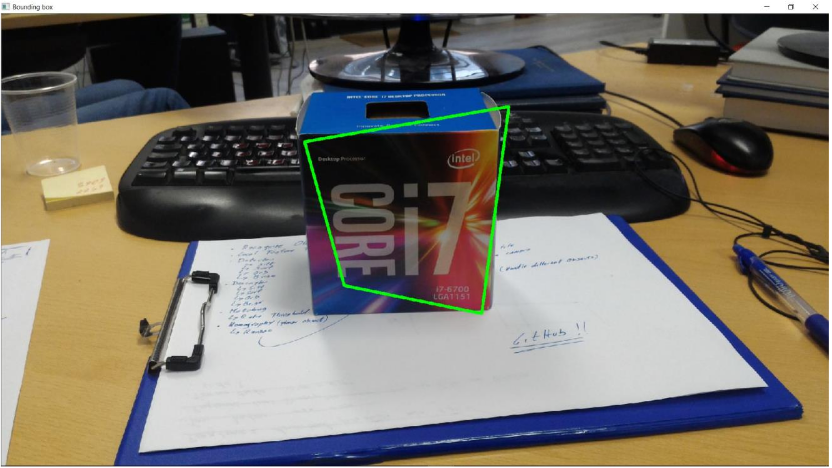

**PROBLEM: some of the matches are completely wrong and the estimated homography can be quite bad...**

We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

### RANSAC algorithm:
Given a set of observation $O=\{o_1...o_n\}$ and a certain parametric model $M$, repeat iteratively:
1. Pick a random (small) subset $I$ of $O$ called inlier set;
2. Fit a model $M_i$ according to the observations in $I$;
3. Test all the other observations against $M_i$, add to a new set $C$ (consensus set) all the observations that fit $M_i$ according to a model specific loss function;
4. If the consensus set is bigger than the one associated with the current best model $M_b$, proceed to step 5, other way return to step 1;
5. Re-compute $M_i$ according to the observations in $I \cup C$, then set $M_b=M_i$. Restart from step 1.

The procedure is repeated for a fixed amount of steps, at the end the best model is returned.

A simple example of RANSAC result used to fit a line to a set of 2D point with Euclidean distance as loss function:
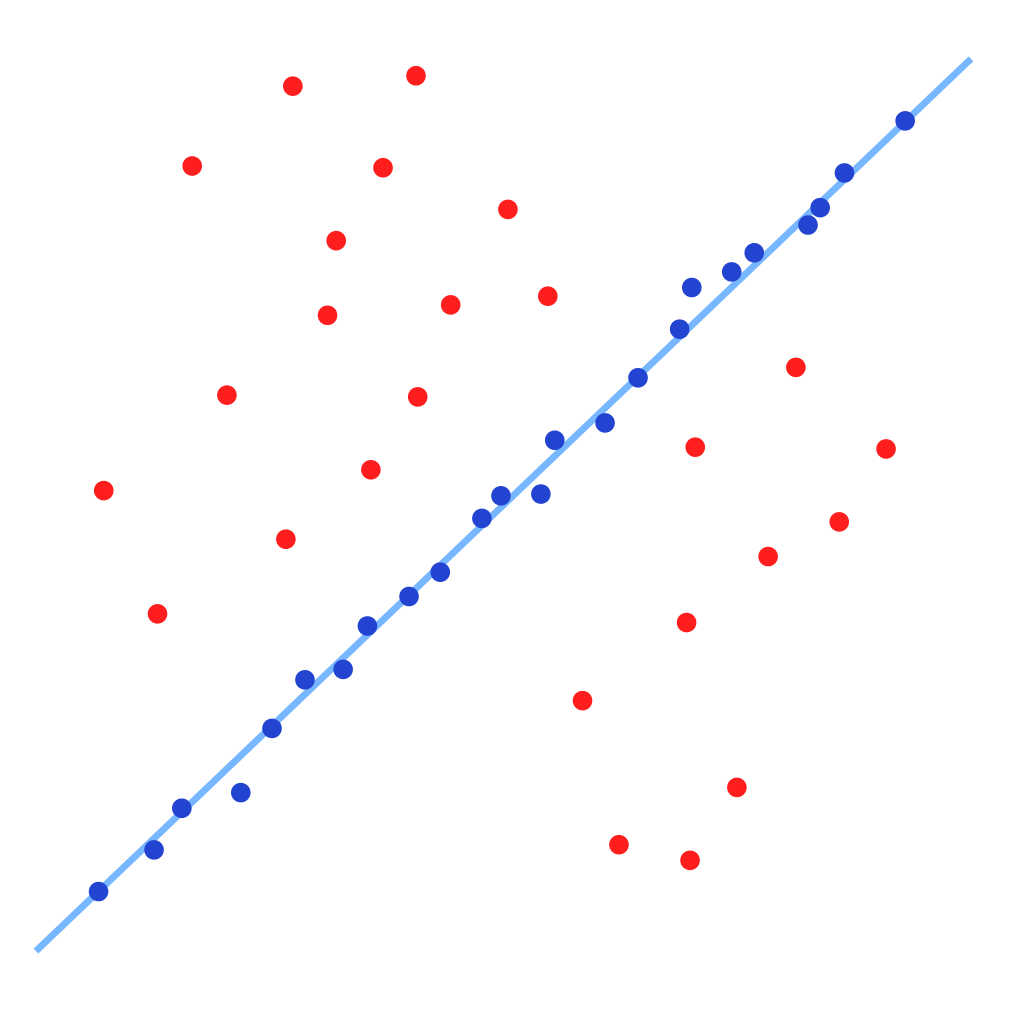

In our case we use the homography as parametric model and the reprojection error as loss function.

If we compute a bounding box transforming the corner of the model image in the scene image reference system with an Homography computed using RANSAC we obtain the following result:

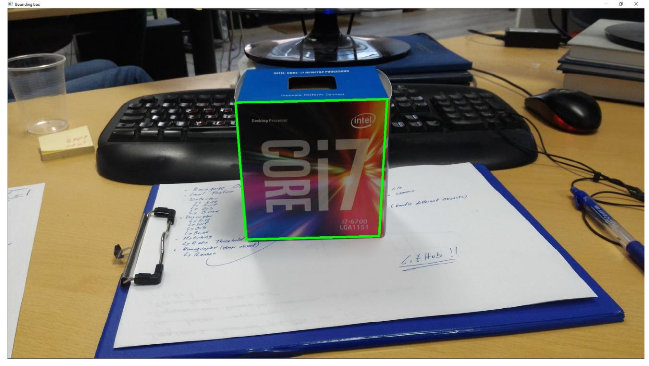


### 3.6 Implementation in OpenCV

Given the set of good matches found before we can perform the following step to find the position of the query object in the train image:
* We set a condition that at least N matches (defined by `MIN_MATCH_COUNT`) have to be there to find the object;
* If enough matches are found, we extract the locations of matched keypoints in both the images building correspondences arrays;
* We use the correspondences to estimate an homography;
* Once we get this 3x3 transformation matrix, we use it to transform the corners of the query image to corresponding points in train image.

In [ ]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2) # source
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2) # destination
    # Using RANSAC to estimate a robust homography.
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    #homography, useless matches    #from    #to    #algo

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()

    # Corners of the query image
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)

    # Drawing the bounding box
    img_train_p = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

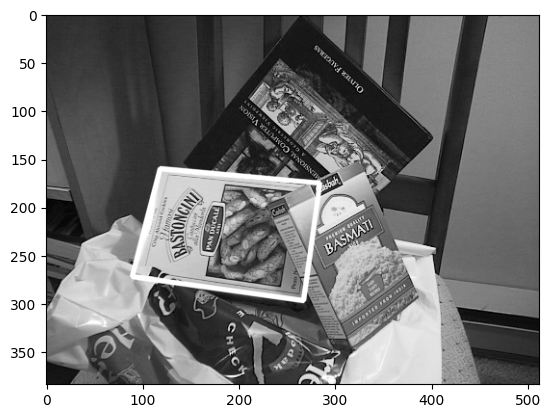

In [ ]:
plt.imshow(img_train_p, 'gray')
plt.show()

Finally, if we want to draw the matches we can do it in the following way:

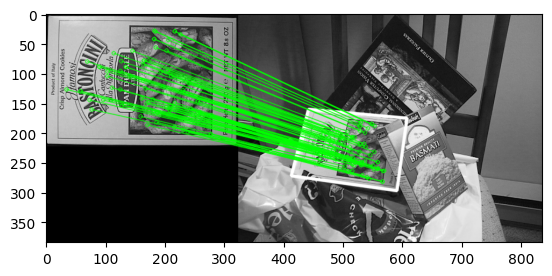

In [ ]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

# Excercises

## Exercise 1: Image search
Given a query image (`bishop.jpg`) and several train images (`scene1.jpg`, `scene2.jpg`, `scene3.jpg`, `scene4.jpg` and `scene5.jpg`) implement an image search algorithm to find which images contain the query object.

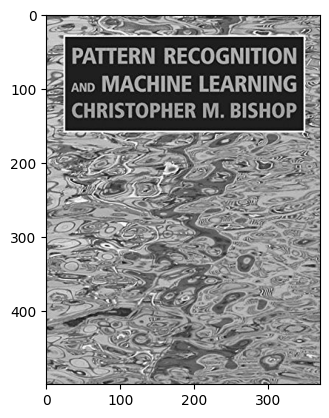

Found query object in scene1.jpg:True


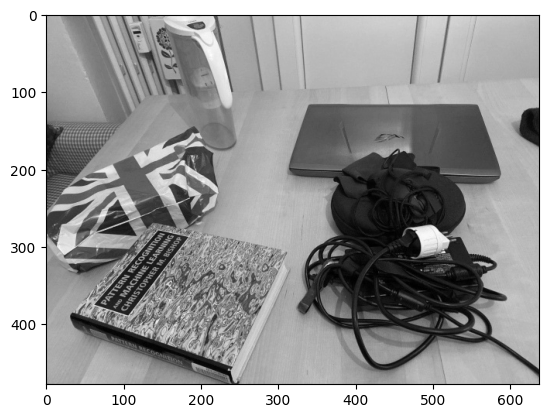

Found query object in scene2.jpg:True


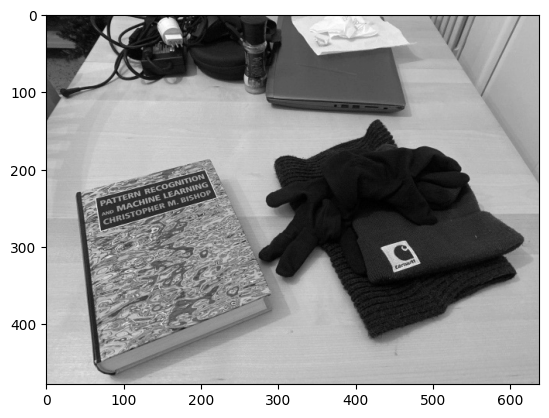

Found query object in scene3.jpg:True


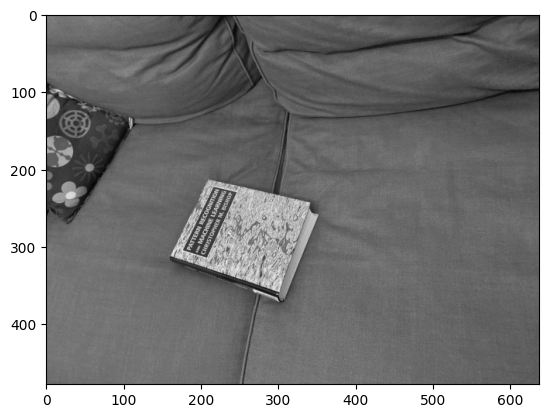

Found query object in scene4.jpg:False
Found query object in scene5.jpg:False


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define a function for object detection pipeline
def object_retrieve(img_query, img_train, min_match_count):

    ############ Write your code here ############

    # create sift detector, detect keypoints and compute descroptors
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    # keypoints matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query, des_train, k=2)

    # Filter good matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Return the count of good matches
    return len(good_matches)
    #############################################


img_query = cv2.imread('bishop.jpg', 0) # queryImage

plt.imshow(img_query, cmap='gray')
plt.show()

imgs_train = ['scene1.jpg', 'scene2.jpg', 'scene3.jpg', 'scene4.jpg', 'scene5.jpg']

# Iterating among all train images and looking for the query object.
for path in imgs_train:
    img_train = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    found = object_retrieve(img_query, img_train, 50)
    print("Found query object in {}:{}".format(path,found > 20))
    if found > 20:
        plt.imshow(img_train, 'gray', vmin= 0, vmax=255)
        plt.show()

## Exercise 2: Mosaicing (aka Panorama Stitching)

Given two images stitch them in a single image.

Test it on `panorama_left_rgb.jpg` and `panorama_right_rgb.jpg`, and also with `panorama_left.jpg` and `panorama_right.jpg`.

_Tips:_
* Find correspondences between the two images;
* Find an homography;
* Warp one image and restore values for the other image.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Loading images
img1 = cv2.imread('panorama_left_rgb.jpg')[:,:,::-1] # grb
img2 = cv2.imread('panorama_right_rgb.jpg')[:,:,::-1] #rgb
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

############ Write your code here ############
# Getting correspondences

sift = cv2.xfeatures2d.SIFT_create()
kp1 = sift.detect(img1)
kp2 = sift.detect(img2)
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k = 2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
      good.append(m)

#############################################


############ Write your code here ############
# Finding an homography
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2) # source
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2) # destination
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(16,8))
plt.imshow(img3)
plt.show()
#############################################


############ Write your code here ############

# Warping right image with the homography
result = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img1.shape[0]))

# Restoring left image values into the result image
result[:img1.shape[0], img1.shape[1]:] = img2

# Displaying the result
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()
#############################################

Output hidden; open in https://colab.research.google.com to view.

## Exercise 3: Augmentated Reality
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping.

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

Scene Image


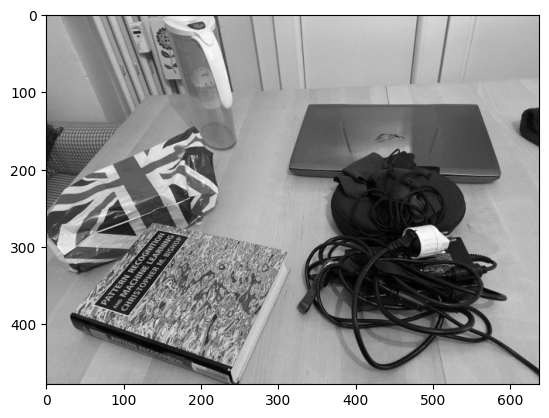

Query Image


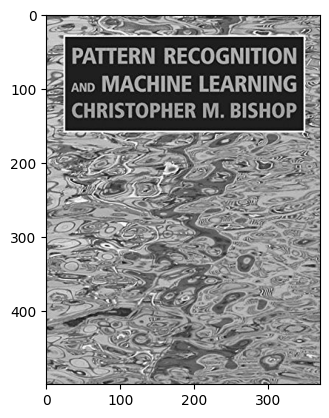

Image to Project


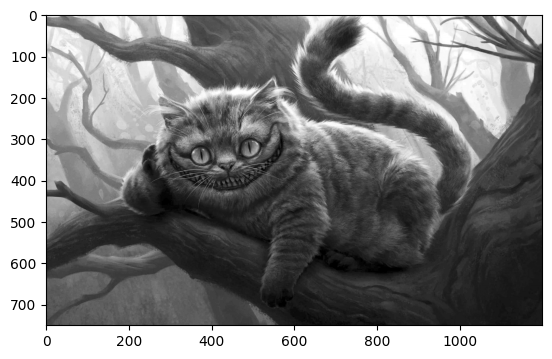

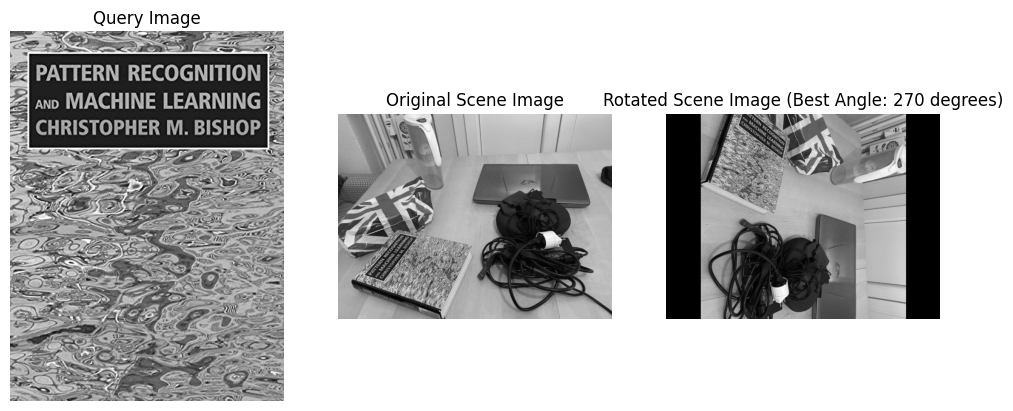

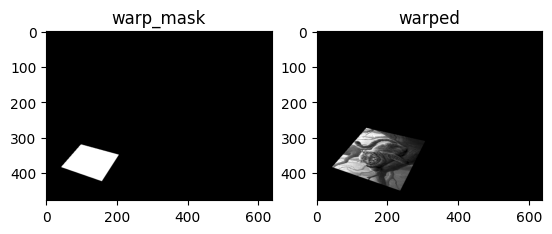

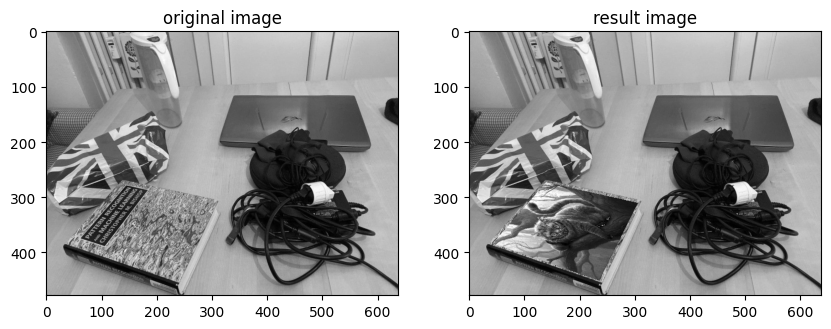

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Loading images
img_train = cv2.imread('scene1.jpg',cv2.IMREAD_GRAYSCALE) # trainImage
img_query = cv2.imread('bishop.jpg',cv2.IMREAD_GRAYSCALE) # queryImage
img_ar = cv2.imread('stregatto.jpg',cv2.IMREAD_GRAYSCALE) # queryImage

print("Scene Image")
plt.imshow(img_train, cmap = 'gray')
plt.show()
print("Query Image")
plt.imshow(img_query, cmap = 'gray')
plt.show()
print("Image to Project")
plt.imshow(img_ar, cmap = 'gray')
plt.show()

'''
# Define rotation angles to test
angles = np.arange(-180, 180, 10)  # Test angles from -10 to 10 degrees

# Initialize variables to store best rotation angle and corresponding score
best_angle = 0
best_score = -np.inf

# Iterate through each angle
for angle in angles:
    # Rotate the scene image
    rotated_scene = cv2.warpAffine(img_train, cv2.getRotationMatrix2D((img_train.shape[1]//2, img_train.shape[0]//2), angle, 1), (img_train.shape[1], img_train.shape[0]))

    # Perform template matching
    result = cv2.matchTemplate(rotated_scene, img_query, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Update best score and angle if current score is better
    if max_val > best_score:
        best_score = max_val
        best_angle = angle

# Rotate scene image by best angle
print(f"best angle is {best_angle}")
rotated_scene = cv2.warpAffine(img_train, cv2.getRotationMatrix2D((img_train.shape[1]//2, img_train.shape[0]//2), best_angle, 1), (img_train.shape[1], img_train.shape[0]))
'''

# Get image height and width
height, width = img_train.shape

# Define the rotation angle
angle = 270  # Change this angle as needed (270 is suggested)

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width//2, height//2), angle, 1)

# Apply the rotation
rotated_img = cv2.warpAffine(img_train, rotation_matrix, (width, height)) # ruota in senso orario

# Display results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_query, cmap='gray')
plt.title('Query Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_train, cmap='gray')
plt.title('Original Scene Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(rotated_img, cmap='gray')
plt.title('Rotated Scene Image (Best Angle: {} degrees)'.format(angle))
plt.axis('off')

plt.show()

# Implementing the object detection pipeline
sift = cv2.xfeatures2d.SIFT_create()
kp_query = sift.detect(img_query)
kp_train = sift.detect(img_train)
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query, des_train, k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Checking if we found the object
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Getting the coordinates of the corners of our query object in the train image
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M) # where is the book in the scene

    h_t, w_t = img_train.shape
    h,w = img_ar.shape

    # Getting the homography to project img_ar on the surface of the query object.
    pts_stregatto = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    M = cv2.getPerspectiveTransform(pts_stregatto, dst)

    # Warping the img_ar
    warped = cv2.warpPerspective(img_ar, M, (w_t, h_t))

    # Warp a white mask to understand what are the black pixels
    white = np.ones_like(img_train) * 255
    warp_mask = cv2.warpPerspective(white, M, (w_t, h_t))

    # show warpad stregatto and warpwd mask in order ro understand the final part
    plt.subplot(1, 2, 1)
    plt.imshow(warp_mask, cmap='gray')
    plt.title('warp_mask')
    plt.subplot(1, 2, 2)
    plt.imshow(warped, cmap='gray')
    plt.title('warped')
    plt.show()

    # Restore previous values of the train images where the mask is black
    warp_mask = warp_mask == warped
    warped[warp_mask] = img_train[warp_mask]

    # Displaying the result
    plt.figure(figsize = (10, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(img_train, cmap='gray')
    plt.title('original image')
    plt.subplot(1, 2, 2)
    plt.imshow(warped, cmap='gray')
    plt.title('result image')
    plt.show()
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
